#### Error Log Data Cleaning and Manipulation Functions

In [197]:
import sys
from collections import defaultdict
import datetime
import json
import pandas as pd
import numpy as np
import itertools
from scipy import integrate

col_delim = ';'

def load(filename):
    with open(filename, 'r', errors='backslashreplace') as f:
        lines = [line.rstrip('\n') for line in f.readlines()]
    return lines

def df_from(headers, lines):
    df = defaultdict(list)
    for line in lines:
        for header, cell in zip(headers, line.split(col_delim)):
            df[header].append(cell)
    return df

def log_timestamp(df, fmt):
    '''Converting timestamp string to datetime in the dataframe.
    '''
    df['timestamp'] = pd.to_datetime(df['timestamp'], format=fmt)
    return df

def err_log_dataframe(filename):
    headers = ["timestamp", "severity", "UNUSED", "message", "code", "source", "call chain"]
    err_log_dict = df_from(headers, load(filename))
    df = pd.DataFrame.from_dict(err_log_dict)
    
    fmt = '%Y%m%d%H%M%S.%f'
    '%m/%d/%Y %H:%M:%S.%f'
    df = log_timestamp(df, fmt)
    
    #Setting Relative Time to start at the start as log
    add_relative_time(df)
    
    return df

def split_sensor_message(message):
    '''Splits message column to get relevant sensor data in this to be used to
    create new columns.
    '''
    prefix = "Sensor Data: "
    _, raw_json = message.split(prefix, 1)
    data_point = json.loads(raw_json, strict=False)
    sensor_id = int(data_point["Sensor ID"])
    value = float(data_point["Value (mg/dL)"])
    return pd.Series([sensor_id, value])

def get_sensor_dfs(df):
    '''Take the error log dataframe and filters out sensor data and returns a list of 
    dataframes for individual sensor data (for this data their are only 2 sensors so 2 
    dataframes will be returned)
    '''
    prefix = "Sensor Data: "
    sensor_df = df[df['message'].str.contains(prefix)]
    sensor_df = sensor_df.reset_index(drop=True)
    
    #adding columns for sensor_id and glucose value from the message using split_sensor_message
    sensor_df[['Sensor ID', 'Glucose (mg/dL)']] = sensor_df['message'].apply(lambda x: split_sensor_message(x))
    
    sensor_df_list = []
    
    num_sensors = sensor_df['Sensor ID'].nunique()
    for i in range(num_sensors):
        sensor_filtered_df = sensor_df[sensor_df['Sensor ID'] == i]
        sensor_filtered_df = sensor_filtered_df.reset_index(drop=True)
        
        # If you want everything to be anchored to the same time stamps,
        # leave this commented. It essentially resets the 0-point in the 
        # timestamps to be wherever the minimum time in the filtered dataframe is.
        #add_relative_time(sensor_filtered_df)
        
        sensor_df_list.append(sensor_filtered_df)
        
    return sensor_df_list

def add_relative_time(sensor_df, conversion='m'):
    '''The timestamp column gives an absolute time, which is great for traceability,
    but does not graph well. This function adds a rel_time column which is the number
    of minutes (by default, see conversion kwarg) since the start of the log. 
    This can be used to have plots begin at time 0 minutes.
    '''
    min_timestamp = (sensor_df['timestamp'].min())
    sensor_df['rel_time'] = sensor_df['timestamp'].apply(lambda x: (x - min_timestamp)/np.timedelta64(1, conversion))
    return sensor_df

def split_pump_message(message, prefix):
    '''Splits message column to get relevant pump data in this to be used to
    create a new column.
    '''
    _, contents = message.split(prefix)
    bucket = contents.split(' ')
    rate = float(bucket[0])
    substance = bucket[2].replace(',', '')
    return pd.Series([rate, substance])

def get_pump_df(df, substance=None):
    '''Get a dataframe containing pump rate data, and time in minutes
    '''
    if substance not in {"Insulin", "Dextrose"}:
        raise ValueError("Invalid substance, needs to be either 'Insulin' or 'Dextrose'")
        
    prefix = "changing pump rate to "
    pump_rate_df = df[df['message'].str.contains(prefix)]
    pump_rate_df = pump_rate_df.reset_index(drop=True)

    # If you want everything to be anchored to the same time stamps,
    # leave this commented. It essentially resets the 0-point in the 
    # timestamps to be wherever the minimum time in the filtered dataframe is.
    #add_relative_time(sensor_filtered_df)
    
    pump_rate_df[["Rate (mL/hr)", "Substance"]] = pump_rate_df['message'].apply(lambda x: split_pump_message(x, prefix))

    return pump_rate_df[pump_rate_df['Substance'] == substance]


def plot_sensor_data(df):
    # Example usage of the sensor dataframes
    import matplotlib.pyplot as plt
    frames = get_sensor_dfs(df)
    for i, frame in enumerate(frames):
        plt.plot(frame["rel_time"], frame["Glucose (mg/dL)"], label=f"ID {i}")

    plt.legend(loc='upper right')
    plt.show()

def plot_pump_data(df):
    import matplotlib.pyplot as plt
    substances = ["Insulin", "Dextrose"]
    frames = [get_pump_df(df, substance) for substance in substances]
    for substance, frame in zip(substances, frames):
        plt.plot(frame["rel_time"], frame["Rate (mL/hr)"], label=substance)

    plt.legend(loc='upper right')
    plt.show()
    
    
def df_filter(err_log_df, filter_key=None, filter_fn=None):
    '''Evaluates filter_fn(value) for every value of 'filter_key' in the dataframe.

    Returns a dataframe with all series truncated to only indices for which this
    filter function evaluates to True'''

    # Make a copy since modifying dictionaries affects original
    err_log_df = err_log_df.copy()

    if filter_fn is None:
        return err_log_df
    if filter_key is None:
        raise ValueError("Must provide a dataframe key whose values to which we apply the filter")

    keys = list(err_log_df.keys())
    
    include = [filter_fn(x) for x in err_log_df[filter_key]]
    for key in keys:
        kept = [x for x, keep in zip(err_log_df[key], include) if keep]
        err_log_df[key] = kept

    return err_log_df
    
def get_app_setup_info(filename):
    '''Get dictionaries containing MR Number, weight, Initial glucose, etc.

    See: Working With IMT Data Products/Application Setup Information Parsing
    for a detailed explanation of this process

    Returns a tuple of dictionaries mapping output parameter names to "String Value" and "Double Value"

    If you want to, for example, access the weight (a floating point value), you can do it like so:
    _, info_floats = get_app_setup_info(df)
    weight = info_floats["Weight"]

    If you want to, for example, access the anonymized patient record number, aka MR Number (a string),
    you can do it like so:
    info_strings, _ = get_app_setup_info(df)
    mr_number = info_strings["MR Number"]
    '''
    
    headers = ["timestamp", "severity", "UNUSED", "message", "code", "source", "call chain"]
    df = df_from(headers, load(filename))
    
    app_setup_df = df_filter(df, "message", lambda x: "Output Parameters" in x)
    app_setup_json = app_setup_df["message"][0]
    app_setup_raw = json.loads(app_setup_json)
    app_setup_info_strings = {}
    app_setup_info_floats = {}

    for i in range(8):
        name_key = f"Output Parameters[{i}]:Output Parameter Name"
        string_value_key = f"Output Parameters[{i}]:String Value"
        float_value_key = f"Output Parameters[{i}]:Double Value"

        name = app_setup_raw[name_key]
        s = app_setup_raw[string_value_key]
        d = float(app_setup_raw[float_value_key])

        app_setup_info_strings[name] = s
        app_setup_info_floats[name] = d

    return app_setup_info_strings, app_setup_info_floats

In [198]:
#creating the dataframe from the dictionary 
err_log_df = err_log_dataframe("../IMT_ERROR_LOG_20210718014240.log")
err_log_df.head()

,timestamp,severity,UNUSED,message,code,source,call chain,rel_time
0,2021-07-18 01:42:40.473112,LOG_INFO,None,Current Git Commit Revision/Hash: aff6f3d65737...,0000,,ApplicationType.lvclass:Record Git Revision.vi...,0.000000
1,2021-07-18 01:42:40.474105,LOG_INFO,None,"IMT Application Configuration: {\t""Disable Sta...",0000,,ApplicationType.lvclass:Record Global Config.v...,0.000017
2,2021-07-18 01:42:40.474105,LOG_INFO,None,"RGVISA Feature: {\t""Use RGVISA?"": ""FALSE""}",0000,,ApplicationType.lvclass:Record RGVISA config.v...,0.000017
3,2021-07-18 01:43:08.246933,LOG_DEBUG,None,Attempting to abort VI: RunHardware.lvclass:Us...,1000,Invoke Node in Utilities.lvclass:Abort VI if R...,Utilities.lvclass:Abort VI if Running.vi in Ru...,0.462897
4,2021-07-18 01:43:35.082033,LOG_DEBUG,None,Attempting to abort VI: RunHardware.lvclass:Us...,1000,Invoke Node in Utilities.lvclass:Abort VI if R...,Utilities.lvclass:Abort VI if Running.vi in Ru...,0.910149


In [199]:
print(get_app_setup_info("../IMT_ERROR_LOG_20210718014240.log"))

({'Control Range Minimum': '100 mg/dL', 'Control Range Maximum': '140 mg/dL', 'Initial Glucose': '100.000000', 'MR Number': 'IMT/test/closed/06', 'Weight': '80.000000', 'Insulin Concentration': '1.0', 'Dextrose Concentration': 'D10%', 'Glucose Units': 'mg/dL'}, {'Control Range Minimum': 100.0, 'Control Range Maximum': 140.0, 'Initial Glucose': 100.0, 'MR Number': 6.0, 'Weight': 80.0, 'Insulin Concentration': 1.0, 'Dextrose Concentration': 10.0, 'Glucose Units': nan})


In [200]:
dfs = get_sensor_dfs(err_log_df)

sensor0_df = dfs[0]
sensor1_df = dfs[1]
sensor1_df.head()

,timestamp,severity,UNUSED,message,code,source,call chain,rel_time,Sensor ID,Glucose (mg/dL)
0,2021-07-18 01:47:23.712450,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,4.720656,1.0,108.0
1,2021-07-18 01:52:25.946527,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,9.757890,1.0,108.0
2,2021-07-18 01:57:28.230346,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,14.795954,1.0,107.0
3,2021-07-18 02:02:31.173613,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,19.845008,1.0,115.0
4,2021-07-18 02:07:33.497915,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,24.883747,1.0,127.0


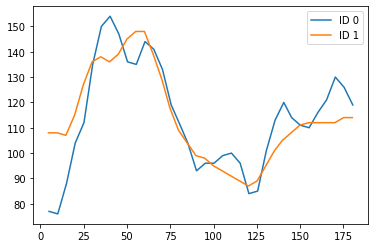

In [201]:
plot_sensor_data(err_log_df)

In [202]:
pump_rate_df = get_pump_df(err_log_df, substance='Dextrose')
pump_rate_df.head()

,timestamp,severity,UNUSED,message,code,source,call chain,rel_time,Rate (mL/hr),Substance
0,2021-07-18 01:43:42.590149,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,1.035284,0.0,Dextrose
2,2021-07-18 01:44:52.668798,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,2.203261,0.0,Dextrose
4,2021-07-18 01:45:52.760831,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,3.204795,0.0,Dextrose
6,2021-07-18 01:47:02.854514,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,4.373023,0.0,Dextrose
8,2021-07-18 01:48:12.949319,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,5.541270,0.0,Dextrose


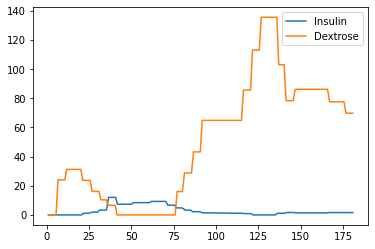

In [203]:
plot_pump_data(err_log_df)

#### Data Log Manipulation, Cleaning and Analysis Functions

In [204]:
def get_data_log_df_setup(csv_file):
    '''This function returns a dateframe and dictionary. The dictionary contrains set up info
    (first couple lines of the csv files) and converts the rest of the csv into a dataframe.
    '''
    df = pd.read_csv(csv_file, skiprows=2)
    setup_df = pd.read_csv(csv_file, on_bad_lines='skip', nrows=2)
    setup_info = setup_df.to_dict('records')
    return [df, setup_info[0]]

def get_glycemia_percentages(err_log_df, data_log_df):
    '''This function takes both the err_log_df and the data_log_df and returns the 
    severe hypoglycemia, hypoglycemia, normoglycemia, and hyperglycemia calculations
    and returns a df containing the calculations for each series (sensor ID 0, sensor
    ID 1 and the average from the data log).
    '''

    dfs = get_sensor_dfs(err_log_df)
    sensor0_df = dfs[0]
    sensor1_df = dfs[1]
    df_list = [data_log_df, sensor0_df, sensor1_df]
    df_labels = ['Data Log', 'Sensor 0', 'Sensor 1']

    bins = [float('-inf'), 39.99, 69.99, 140, float('inf')]
    labels = ['Severe hypoglycemia', 'Hypoglycemia', 'Normoglycemia', 'Hyperglycemia']

    perc_df = pd.DataFrame(columns=labels)

    for (i, j) in zip(df_list, df_labels):
        #Creating a column in df that assigns a category to the glucose value in each row
        i['Glucose Category'] = pd.cut(i['Glucose (mg/dL)'], bins=bins, labels=labels)
        num_entries = len(i)
        
        #Getting the number of counts for each category and calculating the percentage
        cat_counts = pd.value_counts(i['Glucose Category']).reindex(labels, fill_value=0).to_frame('count')
        cat_counts[j] = (cat_counts['count']/num_entries)*100
        
        #Dropping unneccesary rows and transposing to be ready to merge with percentage df for all series
        cat_counts.drop('count', inplace=True, axis=1)
        cat_counts = cat_counts.T
        perc_df = pd.concat([perc_df,cat_counts])
        
    return perc_df

In [205]:
data_log_file = '../IMT_data_log_2021_07_18_0148.csv'
setup_info = get_data_log_df_setup(data_log_file)[1]
print(setup_info)

{'Subject Study ID': 'IMT/test/closed/06', 'Patient Weight (kg)': 80.0, 'Control Range': '100 - 140 mg/dL', 'Insulin Concentration (U/mL)': 1.0, 'Dextrose Concentration (g/100mL)': 10.0, 'IMT Version': '2019_01_14', 'Git Commit': 'aff6f3d65737b47da49617968cc32d5ac8b9a0c0'}


In [206]:
data_log_df = get_data_log_df_setup('../IMT_data_log_2021_07_18_0148.csv')[0]
data_log_df.head()

,Controller Time (min),System Time,Glucose (mg/dL),Insulin Pump 25th,Insulin Pump 50th,Insulin Pump 75th,Dextrose Pump 25th,Dextrose Pump 50th,Dextrose Pump 75th,Controller Insulin 25th,Controller Insulin 50th,Controller Insulin 75th,Controller Dextrose 25th,Controller Dextrose 50th,Controller Dextrose 75th,Controller Private Data,Sensor Algorithm,Notes
0,0,2021-07-18T01:43:38.613Z,100.0,0.00,0.00,0.00,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.000,0.000,NONE,NONE,NONE
1,5,2021-07-18T01:48:38.619Z,93.0,0.00,0.00,0.00,24.000,24.000,24.000,0.00,0.00,0.00,24.000,24.000,24.000,NONE,NONE,NaN
2,10,2021-07-18T01:53:38.624Z,92.0,0.00,0.00,0.00,31.200,31.200,31.200,0.00,0.00,0.00,31.200,31.200,31.200,NONE,NONE,NaN
3,15,2021-07-18T01:58:38.628Z,98.0,0.00,0.00,0.00,31.200,31.200,31.200,0.00,0.00,0.00,31.200,31.200,31.200,NONE,NONE,NaN
4,20,2021-07-18T02:03:38.633Z,110.0,1.12,1.12,1.12,23.712,23.712,23.712,1.12,1.12,1.12,23.712,23.712,23.712,NONE,NONE,NaN


In [207]:
perc_df = get_glycemia_percentages(err_log_df, data_log_df)
perc_df.head()

,Severe hypoglycemia,Hypoglycemia,Normoglycemia,Hyperglycemia
Data Log,0.0,0.0,86.206897,13.793103
Sensor 0,0.0,0.0,86.111111,13.888889
Sensor 1,0.0,0.0,91.666667,8.333333


In [208]:
err_log_df.head()

,timestamp,severity,UNUSED,message,code,source,call chain,rel_time
0,2021-07-18 01:42:40.473112,LOG_INFO,None,Current Git Commit Revision/Hash: aff6f3d65737...,0000,,ApplicationType.lvclass:Record Git Revision.vi...,0.000000
1,2021-07-18 01:42:40.474105,LOG_INFO,None,"IMT Application Configuration: {\t""Disable Sta...",0000,,ApplicationType.lvclass:Record Global Config.v...,0.000017
2,2021-07-18 01:42:40.474105,LOG_INFO,None,"RGVISA Feature: {\t""Use RGVISA?"": ""FALSE""}",0000,,ApplicationType.lvclass:Record RGVISA config.v...,0.000017
3,2021-07-18 01:43:08.246933,LOG_DEBUG,None,Attempting to abort VI: RunHardware.lvclass:Us...,1000,Invoke Node in Utilities.lvclass:Abort VI if R...,Utilities.lvclass:Abort VI if Running.vi in Ru...,0.462897
4,2021-07-18 01:43:35.082033,LOG_DEBUG,None,Attempting to abort VI: RunHardware.lvclass:Us...,1000,Invoke Node in Utilities.lvclass:Abort VI if R...,Utilities.lvclass:Abort VI if Running.vi in Ru...,0.910149


In [209]:
sensor0_df.head()

,timestamp,severity,UNUSED,message,code,source,call chain,rel_time,Sensor ID,Glucose (mg/dL)
0,2021-07-18 01:47:45.679785,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,5.086778,0.0,77.0
1,2021-07-18 01:52:47.799057,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,10.122099,0.0,76.0
2,2021-07-18 01:57:50.099517,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,15.160440,0.0,88.0
3,2021-07-18 02:02:52.293190,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,20.197001,0.0,104.0
4,2021-07-18 02:07:54.558325,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,25.234754,0.0,112.0


In [225]:
dextrose_df = get_pump_df(err_log_df, 'Dextrose')
dextrose_df[0:50]

,timestamp,severity,UNUSED,message,code,source,call chain,rel_time,Rate (mL/hr),Substance
0,2021-07-18 01:43:42.590149,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,1.035284,0.000000,Dextrose
2,2021-07-18 01:44:52.668798,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,2.203261,0.000000,Dextrose
4,2021-07-18 01:45:52.760831,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,3.204795,0.000000,Dextrose
6,2021-07-18 01:47:02.854514,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,4.373023,0.000000,Dextrose
8,2021-07-18 01:48:12.949319,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,5.541270,0.000000,Dextrose
10,2021-07-18 01:49:20.300085,LOG_DEBUG,None,changing pump rate to 24.000000 mL/hr Dextrose...,0000,,RunHardware.lvclass:Handle Pump User Event.vi:...,6.663783,24.000000,Dextrose
12,2021-07-18 01:50:20.377678,LOG_DEBUG,None,changing pump rate to 24.000000 mL/hr Dextrose...,0000,,RunHardware.lvclass:Handle Pump User Event.vi:...,7.665076,24.000000,Dextrose
14,2021-07-18 01:51:20.457061,LOG_DEBUG,None,changing pump rate to 24.000000 mL/hr Dextrose...,0000,,RunHardware.lvclass:Handle Pump User Event.vi:...,8.666399,24.000000,Dextrose
16,2021-07-18 01:52:20.532891,LOG_DEBUG,None,changing pump rate to 24.000000 mL/hr Dextrose...,0000,,RunHardware.lvclass:Handle Pump User Event.vi:...,9.667663,24.000000,Dextrose
18,2021-07-18 01:53:20.878401,LOG_DEBUG,None,changing pump rate to 24.000000 mL/hr Dextrose...,0000,,RunHardware.lvclass:Handle Pump User Event.vi:...,10.673421,24.000000,Dextrose


In [62]:
print(dextrose_df['rel_time'].min())
print(dextrose_df['rel_time'].max())

1.03528395
180.70726375


In [226]:
class GlucoseStats:
    def __init__(self, err_log_df, data_log_df):
        self.mean_agg = get_glucose_stats(err_log_df, data_log_df)['Data Log'][0]
        self.cv_agg = get_glucose_stats(err_log_df, data_log_df)['Data Log'][1]
        self.mean_sensor_0 = get_glucose_stats(err_log_df, data_log_df)['Sensor 0'][0]
        self.cv_sensor_0 = get_glucose_stats(err_log_df, data_log_df)['Sensor 0'][1]
        self.mean_sensor_1 = get_glucose_stats(err_log_df, data_log_df)['Sensor 1'][0]
        self.cv_sensor_1 = get_glucose_stats(err_log_df, data_log_df)['Sensor 1'][1]


def get_glucose_stats(err_log_df, data_log_df):
    '''This function takes both the err_log_df and the data_log_df and returns the 
    mean and cv for each individual sensor.
    '''

    dfs = get_sensor_dfs(err_log_df)
    sensor0_df = dfs[0]
    sensor1_df = dfs[1]
    df_list = [data_log_df, sensor0_df, sensor1_df]
    df_labels = ['Data Log', 'Sensor 0', 'Sensor 1']
    
    my_dict = {}
        
    for (i, j) in zip(df_list, df_labels):
        mean = i['Glucose (mg/dL)'].mean()
        std = i['Glucose (mg/dL)'].std()
        cv = (100 * std)/mean
        my_dict[j] = [mean, cv]
        
    return my_dict


def get_dextrose_rate_stats(err_log_df, setup_info):
    #volume in mL = integral over all time for a given rate (all rates are mL/hr so integral will be mL)
    #mg of dextrose = [dex concentration] * 1 g/100mL * volumne in mL * 1000mg/g
    #mg/kg/min = mg of dextrose / patient weight / total time in minutes
    
    dextrose_rate_df = get_pump_df(err_log_df, 'Dextrose')
    
    volume = integrate.trapz(dextrose_rate_df['Rate (mL/hr)'], x=dextrose_rate_df['rel_time'])
    dex_concentration = setup_info['Dextrose Concentration (g/100mL)']
    
    mg_dextrose = dex_concentration * (1/100) * volume * 1000
    
    patient_weight = setup_info['Patient Weight (kg)']
    
    total_time = dextrose_rate_df['rel_time'].max() - dextrose_rate_df['rel_time'].min()
    
    mg_kg_min = mg_dextrose / patient_weight / total_time
    
    print("volume:", volume)
    print("Dex concentration", dex_concentration)
    print("Mg Dextrose", mg_dextrose)
    print("Patient weight", patient_weight)
    print("Total_time", total_time)
    print("mg_kg_min", mg_kg_min)
    return mg_kg_min
    

In [227]:
get_dextrose_rate_stats(err_log_df, setup_info)

volume: 8861.015037561923
Dex concentration 10.0
Mg Dextrose 886101.5037561924
Patient weight 80.0
Total_time 179.66236196666665
mg_kg_min 61.65046855505229


61.65046855505229

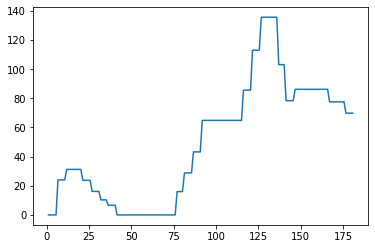

In [228]:
dextrose_rate_df = get_pump_df(err_log_df, 'Dextrose')

import matplotlib.pyplot as plt

plt.plot(dextrose_rate_df['rel_time'], dextrose_rate_df['Rate (mL/hr)'])